## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd
import numpy as np
import nltk

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df = df.dropna()

In [4]:
df = df[0:100000]

In [5]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [6]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
99995,99995,165922,165923,What are some of the most iconic images of foo...,What are some of the most iconic images of women?,0
99996,99996,165924,165925,How green is green tea?,"Why isn't ""green"" tea green?",0
99997,99997,165926,165927,Who would win: Black Panther or Batman?,Who would win in a fight between Black Panther...,1
99998,99998,165928,165929,"Which school is better, for what, and why: Par...",What are some good design schools/colleges on ...,0


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [7]:
df_duplicate = df.groupby(['is_duplicate']).count().reset_index()
df_duplicate

,is_duplicate,id,qid1,qid2,question1,question2
0,0,62746,62746,62746,62746,62746
1,1,37254,37254,37254,37254,37254


### Exploration

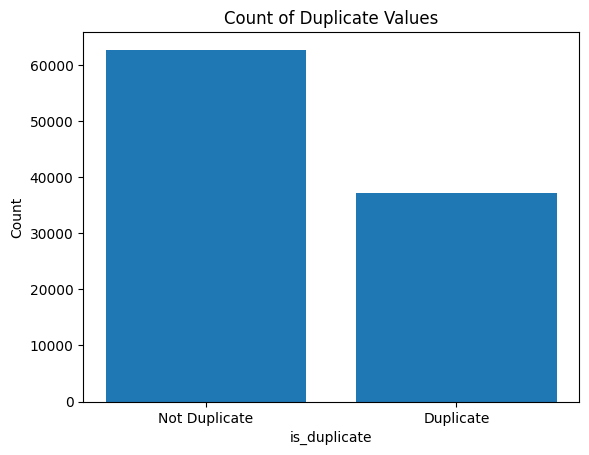

In [8]:
import matplotlib.pyplot as plt

# Create a bar chart of is_duplicate values
plt.bar(df_duplicate['is_duplicate'], df_duplicate['id'])
plt.xlabel('is_duplicate')
plt.ylabel('Count')
plt.title('Count of Duplicate Values')
plt.xticks([0, 1], ['Not Duplicate', 'Duplicate'])
plt.show()

In [9]:
df[df['is_duplicate'] == 1]

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1
...,...,...,...,...,...,...
99983,99983,165905,17577,How can you stop caring about someone who does...,How can I stop caring about a girl who doesn't...,1
99985,99985,165908,133295,What are the best interview questions that are...,What are the best tricky interview questions?,1
99987,99987,165910,165911,What's the best music to listen to while clean...,What's the best background music for cleaning?,1
99988,99988,30057,9835,How QuickBooks Proavisor Tech support Phone Nu...,What is Quickbooks tech support number in Ariz...,1


In [10]:
df.shape

(100000, 6)

In [11]:
len(df)

100000

In [12]:
# In this case, 62.7% will be our baseline for accuracy.
62746/len(df)

0.62746

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [13]:
def text_cleaning(text):
    """
    Removes punctuation, upper case, stop words and stemming from a given text.
    """
    #import required packages
    from nltk.tokenize import word_tokenize
    import string
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    from nltk.stem import PorterStemmer
    stemmer = PorterStemmer()
    
    #tokenize text
    tokens = word_tokenize(text)
    
    #remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    #remove_upper case
    lower = [w.lower() for w in stripped]
    
    # Remove stopwords 
    no_stops = [w for w in lower if w not in stop_words]
    
    #stem words
    stemmed_words = [stemmer.stem(w) for w in no_stops]
    
    # Join words back into text
    clean_text = ' '.join(stemmed_words)
    
    return clean_text

In [14]:
df[0:6]

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1


In [15]:
for i in df['question1'][0:6]:
    print(text_cleaning(i))

step step guid invest share market india 
stori kohinoor  kohinoor  diamond 
increas speed internet connect use vpn 
mental lone  solv 
one dissolv water quikli sugar  salt  methan carbon di oxid 
astrolog  capricorn sun cap moon cap rise  say 


In [16]:
for i in df['question2'][0:6]:
    print(text_cleaning(i))

step step guid invest share market 
would happen indian govern stole kohinoor  kohinoor  diamond back 
internet speed increas hack dn 
find remaind  math  23  24   math  divid 2423 
fish would surviv salt water 
tripl capricorn  sun  moon ascend capricorn  say 


In [17]:
print(df['question1'][5])
print(text_cleaning(df['question1'][5]))

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
astrolog  capricorn sun cap moon cap rise  say 


In [18]:
print(df['question2'][5])
print(text_cleaning(df['question2'][5]))

I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
tripl capricorn  sun  moon ascend capricorn  say 


In [19]:
def process_questions(questions, question_list_name):
# function to transform questions and display progress
    for i,question in enumerate(questions):
        df.loc[i, question_list_name] = text_cleaning(question)
        if i % 10000 == 0:
            progress = i/len(df) * 100
            print("{} is {}% complete.".format(question_list_name, round(progress, 1)))

In [20]:
process_questions(df['question1'], 'question1_clean')

question1_clean is 0.0% complete.
question1_clean is 10.0% complete.
question1_clean is 20.0% complete.
question1_clean is 30.0% complete.
question1_clean is 40.0% complete.
question1_clean is 50.0% complete.
question1_clean is 60.0% complete.
question1_clean is 70.0% complete.
question1_clean is 80.0% complete.
question1_clean is 90.0% complete.


In [21]:
process_questions(df['question2'], 'question2_clean')

question2_clean is 0.0% complete.
question2_clean is 10.0% complete.
question2_clean is 20.0% complete.
question2_clean is 30.0% complete.
question2_clean is 40.0% complete.
question2_clean is 50.0% complete.
question2_clean is 60.0% complete.
question2_clean is 70.0% complete.
question2_clean is 80.0% complete.
question2_clean is 90.0% complete.


In [22]:
df

,id,qid1,qid2,question1,question2,is_duplicate,question1_clean,question2_clean
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guid invest share market india,step step guid invest share market
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor koh...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increas speed internet connect use vpn,internet speed increas hack dn
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mental lone solv,find remaind math 23 24 math divid 2423
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolv water quikli sugar salt methan c...,fish would surviv salt water
...,...,...,...,...,...,...,...,...
99995,99995,165922,165923,What are some of the most iconic images of foo...,What are some of the most iconic images of women?,0,icon imag footbal,icon imag women
99996,99996,165924,165925,How green is green tea?,"Why isn't ""green"" tea green?",0,green green tea,nt green tea green
99997,99997,165926,165927,Who would win: Black Panther or Batman?,Who would win in a fight between Black Panther...,1,would win black panther batman,would win fight black panther batman
99998,99998,165928,165929,"Which school is better, for what, and why: Par...",What are some good design schools/colleges on ...,0,school better parson risd,good design schoolscolleg par risd


In [23]:
df.isnull().sum()

id                 0
qid1               0
qid2               0
question1          0
question2          0
is_duplicate       0
question1_clean    0
question2_clean    0
dtype: int64

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [25]:
tfidf_vectorizer = TfidfVectorizer()
tfidf1 = tfidf_vectorizer.fit_transform([df['question1_clean'][0]])
features = tfidf_vectorizer.get_feature_names_out()
test = pd.DataFrame(tfidf1.toarray(), columns=features)
test

,guid,india,invest,market,share,step
0,0.333333,0.333333,0.333333,0.333333,0.333333,0.666667


In [26]:
tfidf2 = tfidf_vectorizer.fit_transform([df['question2_clean'][0]])
features = tfidf_vectorizer.get_feature_names_out()
test = pd.DataFrame(tfidf2.toarray(), columns=features)
test

,guid,invest,market,share,step
0,0.353553,0.353553,0.353553,0.353553,0.707107


In [27]:
tfidf = tfidf_vectorizer.fit_transform([df['question1_clean'][0],df['question2_clean'][0]])
features = tfidf_vectorizer.get_feature_names_out()
test = pd.DataFrame(tfidf.toarray(), columns=features)
test

,guid,india,invest,market,share,step
0,0.316619,0.444996,0.316619,0.316619,0.316619,0.633237
1,0.353553,0.000000,0.353553,0.353553,0.353553,0.707107


In [28]:
row1 = test.iloc[0]
row2 = test.iloc[1]
similarity = cosine_similarity([row1, row2])
print(similarity)
cosine_similarity_value = similarity[0, 1]  # select the off-diagonal element
cosine_similarity_value

[[1.         0.89553242]
 [0.89553242 1.        ]]


0.8955324150715728

In [29]:
#vectorize question 1 and question 2
tfidf = tfidf_vectorizer.fit_transform([df['question1_clean'][1],df['question2_clean'][1]])

#create a dataframe with the unique words between questions, where each row in the data frame reqpresnts question 1 & 2
features = tfidf_vectorizer.get_feature_names_out()
test = pd.DataFrame(tfidf.toarray(), columns=features)

# find the similarity score between each question (row)
row1 = test.iloc[0]
row2 = test.iloc[1]
similarity = cosine_similarity([row1, row2])
cosine_similarity_value = similarity[0, 1]  # select the off-diagonal element
print(cosine_similarity_value)
test


0.4611709283793984


,back,diamond,govern,happen,indian,kohinoor,stole,stori,would
0,0.000000,0.378632,0.000000,0.000000,0.000000,0.757264,0.000000,0.532154,0.000000
1,0.342369,0.243598,0.342369,0.342369,0.342369,0.487197,0.342369,0.000000,0.342369


In [30]:
print(df['question1'][5])
print(df['question2'][5])

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?


In [31]:
#vectorize question 1 and question 2
tfidf = tfidf_vectorizer.fit_transform([df['question1_clean'][5],df['question2_clean'][5]])

#create a dataframe with the unique words between questions, where each row in the data frame reqpresnts question 1 & 2
features = tfidf_vectorizer.get_feature_names_out()
test = pd.DataFrame(tfidf.toarray(), columns=features)

# find the similarity score between each question (row)
row1 = test.iloc[0]
row2 = test.iloc[1]
similarity = cosine_similarity([row1, row2])
cosine_similarity_value = similarity[0, 1]  # select the off-diagonal element
print(cosine_similarity_value)
test


0.37949655213535355


,ascend,astrolog,cap,capricorn,moon,rise,say,sun,tripl
0,0.000000,0.353003,0.706006,0.251164,0.251164,0.353003,0.251164,0.251164,0.000000
1,0.424717,0.000000,0.000000,0.604380,0.302190,0.000000,0.302190,0.302190,0.424717


In [32]:
print(df['question1'][99997])
print(df['question2'][99997])

Who would win: Black Panther or Batman?
Who would win in a fight between Black Panther and Batman?


In [33]:
#vectorize question 1 and question 2
tfidf = tfidf_vectorizer.fit_transform([df['question1_clean'][99997],df['question2_clean'][99997]])

#create a dataframe with the unique words between questions, where each row in the data frame reqpresnts question 1 & 2
features = tfidf_vectorizer.get_feature_names_out()
test = pd.DataFrame(tfidf.toarray(), columns=features)

# find the similarity score between each question (row)
row1 = test.iloc[0]
row2 = test.iloc[1]
similarity = cosine_similarity([row1, row2])
cosine_similarity_value = similarity[0, 1]  # select the off-diagonal element
print(cosine_similarity_value)
test


0.8466473536503033


,batman,black,fight,panther,win,would
0,0.447214,0.447214,0.000000,0.447214,0.447214,0.447214
1,0.378632,0.378632,0.532154,0.378632,0.378632,0.378632


In [34]:
#vectorize question 1 and question 2
tfidf = tfidf_vectorizer.fit_transform([df['question1_clean'][1],df['question2_clean'][1]])

#create a dataframe with the unique words between questions, where each row in the data frame reqpresnts question 1 & 2
features = tfidf_vectorizer.get_feature_names_out()
test = pd.DataFrame(tfidf.toarray(), columns=features)

# find the similarity score between each question (row)
row1 = test.iloc[0]
row2 = test.iloc[1]
similarity = cosine_similarity([row1, row2])
cosine_similarity_value = similarity[0, 1]  # select the off-diagonal element
print(cosine_similarity_value)
test


0.4611709283793984


,back,diamond,govern,happen,indian,kohinoor,stole,stori,would
0,0.000000,0.378632,0.000000,0.000000,0.000000,0.757264,0.000000,0.532154,0.000000
1,0.342369,0.243598,0.342369,0.342369,0.342369,0.487197,0.342369,0.000000,0.342369


In [35]:
#test function before creating it
tfidf = tfidf_vectorizer.fit_transform([df['question1_clean'][1],df['question2_clean'][1]])
tfidf_array = tfidf.toarray()
similarity = cosine_similarity([tfidf_array[0], tfidf_array[1]])
cosine_similarity_value = similarity[0, 1]  # select the off-diagonal element
print(cosine_similarity_value)
tfidf_array.shape

0.4611709283793984


(2, 9)

In [36]:
def cosine_sim(text1, text2):
    """
    Find the cosine simialrity between 2 questions
    """
    #vectorize question 1 and question 2
    tfidf = tfidf_vectorizer.fit_transform([text1, text2])
    
    #convert matrix to array
    tfidf_array = tfidf.toarray()
    
    # find the similarity score between each question (row of array)
    similarity = cosine_similarity([tfidf_array[0], tfidf_array[1]])
    cosine_similarity_value = similarity[0, 1]
    
    #return similarity score
    return cosine_similarity_value

cosine_sim(df['question1_clean'][1],df['question2_clean'][1])
    

0.4611709283793984

In [37]:
# for i in range(len(df)):
#     try:
#         if len(df['question1_clean'][i]) == 0 | len(df['question2_clean'][i]) == 0:
#             df.loc[i,'question1_clean'] = np.NaN
#         else:
#             df.loc[i,'cosine_similarity'] = cosine_sim(df['question1_clean'][i],df['question2_clean'][i])
#     except:
#         print(i)

for i in range(len(df)):
    try:
        if len(df.at[i, 'question1_clean']) == 0 or len(df.at[i, 'question2_clean']) == 0:
            df.at[i, 'question1_clean'] = np.NaN
        else:
            df.at[i, 'cosine_similarity'] = cosine_sim(df.at[i, 'question1_clean'], df.at[i, 'question2_clean'])
    except Exception as e:
        print(f"Error at index {i}: {e}")

Error at index 60180: empty vocabulary; perhaps the documents only contain stop words
Error at index 88243: empty vocabulary; perhaps the documents only contain stop words


In [40]:
df.isnull().sum()

id                   0
qid1                 0
qid2                 0
question1            0
question2            0
is_duplicate         0
question1_clean      0
question2_clean      0
cosine_similarity    0
dtype: int64

In [39]:
df = df.dropna()

In [41]:
df.to_csv('train_clean.csv')

In [42]:
df[df['is_duplicate'] == 1].sort_values('cosine_similarity').head(20)

,id,qid1,qid2,question1,question2,is_duplicate,question1_clean,question2_clean,cosine_similarity
94566,94566,157896,157897,How could I get started in C#?,How can I learn C#?,1,could get start c,learn c,0.000000
60522,60522,105828,6898,What was there before the 'Big Bang'?,What was there before universe was born?,1,big bang,univers born,0.000000
10477,10477,20290,3658,How can I master C#?,What are the best ways to learn C#?,1,master c,best way learn c,0.000000
51974,51974,92105,15265,How is 0! =1?,Why is 0! equal to 1?,1,0 1,0 equal 1,0.000000
92067,92067,154196,154197,Is it right that males are more sexual than fe...,Do men want sex more than women?,1,right male sexual femal,men want sex women,0.000000
46469,46469,83119,15828,What is the work of IES?,What is the job of an IES?,1,work i,job i,0.000000
81557,81557,99189,138455,Can we prove 0! =1?,How is 0! = 1?,1,prove 0 1,0 1,0.000000
56348,56348,99189,99190,Can we prove 0! =1?,Why does 0! Equal 1?,1,prove 0 1,0 equal 1,0.000000
7820,7820,15264,15265,Why and how is 0! =1?,Why is 0! equal to 1?,1,0 1,0 equal 1,0.000000
59036,59036,103467,99189,How is the value of 0! 1?,Can we prove 0! =1?,1,valu 0 1,prove 0 1,0.000000


In [43]:
df[df['is_duplicate'] == 1].sort_values('cosine_similarity',ascending=False).head(20)

,id,qid1,qid2,question1,question2,is_duplicate,question1_clean,question2_clean,cosine_similarity
61840,61840,10503,107899,"Two cards were drawn, without replacement, fro...","Two cards were drawn, without replacement, fro...",1,two card drawn without replac pack 52 card ...,two card drawn without replac pack 52 card ...,1.0
92007,92007,154102,154103,I am studying in class 12 PCM can some one giv...,I am studying in class 12 PCM can some one giv...,1,studi class 12 pcm one give inform engin entra...,studi class 12 pcm one give inform engin entra...,1.0
10941,10941,21165,10504,Two cards were drawn without a replacement fro...,"Two cards were drawn, without replacement, fro...",1,two card drawn without replac pack 52 card pr...,two card drawn without replac pack 52 card ...,1.0
45166,45166,80960,80961,Can FIFA 17 be played on a Intel Iris Graphics...,Can FIFA 17 be played on a Intel Iris Graphics...,1,fifa 17 play intel iri graphic 6100 1536 mb g...,fifa 17 play intel iri graphic 6100 1536 mb g...,1.0
28345,28345,10503,40864,"Two cards were drawn, without replacement, fro...","Two cards were drawn, without replacement, fro...",1,two card drawn without replac pack 52 card ...,two card drawn without replac pack 52 card ...,1.0
21721,21721,21165,40864,Two cards were drawn without a replacement fro...,"Two cards were drawn, without replacement, fro...",1,two card drawn without replac pack 52 card pr...,two card drawn without replac pack 52 card ...,1.0
5336,5336,10503,10504,"Two cards were drawn, without replacement, fro...","Two cards were drawn, without replacement, fro...",1,two card drawn without replac pack 52 card ...,two card drawn without replac pack 52 card ...,1.0
77946,77946,133003,133004,I am in second year of graduation but I don't ...,"I am in my second year of graduation, but I do...",1,second year graduat nt like cours life citi d...,second year graduat nt like cours life citi ...,1.0
42043,42043,41644,75816,How do i get job in Bangalore ?,How do I get job in Bangalore?,1,get job bangalor,get job bangalor,1.0
41925,41925,75625,75626,When did you have your first orgasm?,When was your first orgasm and how?,1,first orgasm,first orgasm,1.0


In [44]:
print(df['cosine_similarity'].count())
print(df['is_duplicate'].count())

99971
99971


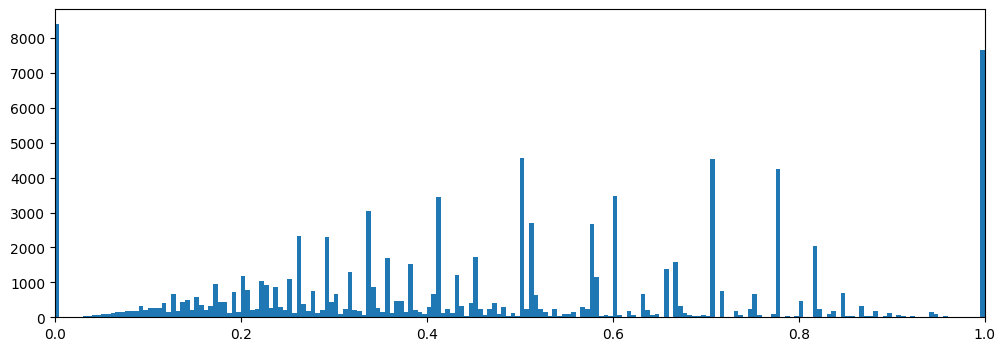

In [45]:
# Plot the scores
plt.figure(figsize=(12,4))
plt.hist(df['cosine_similarity'], bins = 200)
plt.xlim(0,1)
plt.show()

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

In [51]:
X = df['cosine_similarity'].values.reshape(-1, 1)
y = df['is_duplicate']

In [52]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logitic Regressor

In [53]:
# Create a logistic regression model and fit it to the training data
clf = LogisticRegression(solver='lbfgs', C=0.1, penalty='l2')
clf.fit(X_train, y_train)

# Predict the class labels for the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy score of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Calculate the accuracy of the model on the training data
y_train_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_acc)

# Calculate the confusion matrix of the model on the test data
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", confusion)


Test Accuracy: 0.663615903975994
Training accuracy: 0.6598229468840652
Confusion matrix:
 [[10229  2351]
 [ 4375  3040]]


In [241]:
results = pd.DataFrame()
results['y_test'] = y_test
results['X_test'] = X_test.tolist()
results['X_test'] = results['X_test'].apply(lambda X:X[0])
results['y_pred'] = list(y_pred)
results[results['y_pred'] == 1].describe()

,y_test,X_test,y_pred
count,5391.000000,5391.000000,5391.0
mean,0.563903,0.823018,1.0
std,0.495946,0.125283,0.0
min,0.000000,0.649548,1.0
25%,0.000000,0.709297,1.0
50%,1.000000,0.776515,1.0
75%,1.000000,1.000000,1.0
max,1.000000,1.000000,1.0


In [242]:
results[results['y_pred'] == 0].describe()

,y_test,X_test,y_pred
count,14604.000000,14604.000000,14604.0
mean,0.299575,0.324473,0.0
std,0.458088,0.183248,0.0
min,0.000000,0.000000,0.0
25%,0.000000,0.201993,0.0
50%,0.000000,0.336097,0.0
75%,1.000000,0.502329,0.0
max,1.000000,0.648095,0.0


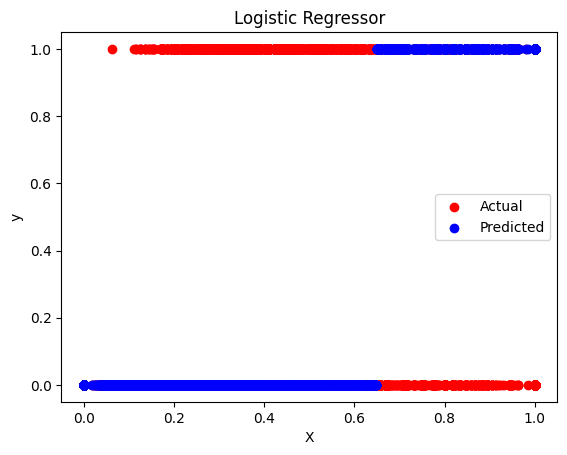

In [57]:
plt.scatter(X_test, y_test, color='red', label = 'Actual')
plt.scatter(X_test, y_pred, color='blue', label = 'Predicted')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Logistic Regressor')
plt.legend()
plt.show()

In [195]:
# from sklearn.model_selection import GridSearchCV

# # Define the hyperparameters to search over
# params = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2', 'none']}

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(clf, param_grid=params, cv=5)
# grid_search.fit(X_train, y_train)

# # Predict on the test set using the best model
# y_pred = grid_search.best_estimator_.predict(X_test)

# # Evaluate the performance of the best model
# accuracy = accuracy_score(y_test, y_pred)
# print('Accuracy: {:.2f}'.format(accuracy))

In [193]:
# Output the best parameters and best score
print('Best Parameters: ', grid_search.best_params_)
print('Best Score: {:.2f}'.format(grid_search.best_score_))

Best Parameters:  {'C': 0.1, 'penalty': 'l2'}
Best Score: 0.66


### XGBoost

In [58]:
# Create a XGBoost model and fit it to the training data
xgb_model = xgb.XGBClassifier(objective='binary:logistic', num_class=1, colsample_bytree = 0.5, 
                              gamma = 0, learning_rate = 0.1, max_depth = 5, n_estimators = 500, subsample = 0.75)
xgb_model.fit(X_train, y_train)

# Predict the class labels for the test data
y_pred = xgb_model.predict(X_test)

# Calculate the accuracy score of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Calculate the accuracy of the model on the training data
y_train_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_acc)

# Calculate the confusion matrix of the model on the test data
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", confusion)


Test Accuracy: 0.6950237559389848
Training accuracy: 0.6598229468840652
Confusion matrix:
 [[10421  2159]
 [ 3939  3476]]


In [59]:
results = pd.DataFrame()
results['y_test'] = y_test
results['X_test'] = X_test.tolist()
results['X_test'] = results['X_test'].apply(lambda X:X[0])
results['y_pred'] = list(y_pred)
results[results['y_pred'] == 1].describe()

,y_test,X_test,y_pred
count,5635.000000,5635.000000,5635.0
mean,0.616859,0.740716,1.0
std,0.486195,0.201463,0.0
min,0.000000,0.315785,1.0
25%,0.000000,0.536893,1.0
50%,1.000000,0.776515,1.0
75%,1.000000,1.000000,1.0
max,1.000000,1.000000,1.0


In [60]:
results[results['y_pred'] == 0].describe()

,y_test,X_test,y_pred
count,14360.000000,14360.000000,14360.0
mean,0.274304,0.348298,0.0
std,0.446178,0.221070,0.0
min,0.000000,0.000000,0.0
25%,0.000000,0.197094,0.0
50%,0.000000,0.336097,0.0
75%,1.000000,0.503103,0.0
max,1.000000,0.980038,0.0


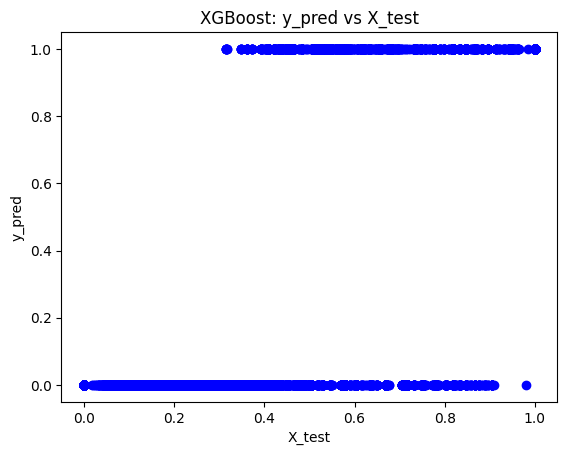

In [61]:
plt.scatter(X_test, y_pred, color='blue')
plt.xlabel('X_test')
plt.ylabel('y_pred')
plt.title('XGBoost: y_pred vs X_test')
plt.show()

In [221]:
# Define the hyperparameter grid to search over
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'gamma': [0, 0.1, 0.2],
}

# Define the grid search object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search object to the training set
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, num_class=1,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.75, 1],
                         'gamma': [0, 0.1, 0.2], 'learning_rate': [0.1, 0.01],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.5, 0.75, 1]})

In [222]:
# Print the best parameters and the corresponding mean test score
print("Best Parameters:", grid_search.best_params_)
print("Best Mean Test Score: {:.2f}".format(grid_search.best_score_))

# Make predictions on the test set using the best model found by grid search
y_pred = grid_search.predict(X_test)

# Evaluate the model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))

Best Parameters: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.75}
Best Mean Test Score: 0.70
Accuracy: 0.70
